# Finite volume method tutorial

We will demonstrate how to numerically solve a **reaction-diffusion equation (RDE)** using the **finite volume method (FVM)**. FVM integrates the dynamics forward in time by obeying mass conservation laws.

To quickly illustrate, consider a simple mass transport process on a spatial domain $\Omega$. At some small region $\omega\subset\Omega$, the mass is

$$
m(t) = \int_\omega \text{d}x\, \rho(x,t),
$$

where $\rho(x,t)$ is the mass density field at time $t$. At any given point, there is a net flow *into* $\omega$ dictated by the flux vector field $\textbf{j}(x,t)$ (which we can think of as the "mass current"). The rate of change of the mass in $\omega$ is then

$$
\frac{\text{d}m}{\text{d}t} = -\int_{\partial\omega} \text{d}S(x)\, \hat{\textbf{n}}(x)\cdot\textbf{j}(x,t),
$$

where the negative sign is from the fact that $\hat{\textbf{n}}$ points *out* of the boundary $\partial\omega$. Using the divergence theorem

$$
\int_\omega \text{d}x\, \frac{\partial\rho}{\partial t} = -\int_\omega \text{d}x\, \nabla\cdot\textbf{j}(x,t).
$$

Since the volume element $\omega$ is arbitrary, we arrive at the PDE we want to solve:

$$
\frac{\partial\rho}{\partial t} = -\nabla\cdot\textbf{j}.
$$

To see how FVM works, let's go back (somewhat unintuitively) to the integral form

$$
\int_\omega \text{d}x\, \frac{\partial\rho}{\partial t} + \int_{\partial\omega} \text{d}S\, \hat{\textbf{n}}\cdot\textbf{j} = 0.
$$

If we discretize the domain $\Omega$ into small Voronoi cells $\{\omega_k\}$ (called **volume elements**), we get neighboring elements that are orthogonal to each other (making $\hat{\textbf{n}}\cdot\textbf{j}$ easy to approximate). The above equation discretizes to the implicit scheme:

$$
V(\omega_k)\frac{\rho_k(t)-\rho_k(t-\Delta t)}{\Delta t} + \sum_{k'\in\mathcal{N}(k)}\Delta S_{k'}\,\frac{J_{k'}(t)}{\Delta x_{k'}} = 0,
$$

where $V(\omega_k)$ is the volume of the $k$-th element, $\mathcal{N}(k)$ are the indices of neighbors of the $k$-th element, $\Delta S_{k'}$ is the length of the edge between the $k$-th and $k'$-th elements, and $\frac{J_{k'}(t)}{\Delta x_{k'}}$ approximates the magnitude of $\textbf{j}$ in the direction orthogonal to the respective edge. Given the previous solution $\{\rho_k(t-\Delta t)\}$, we can use Newton's method to find the roots $\{\rho_k(t)\}$. As an example, if we are modeling a simple diffusion system, $\textbf{j} = -D\nabla\rho$ can be approximated by $J_{k'}(t) = -D(\rho_{k'}(t) - \rho_k(t))$.

Now that we have a basic idea of FVM, let's tackle a more significant example, featuring nonlinear diffusion. We will need the following Julia packages:

In [1]:
using PyCall, VoronoiFVM, ExtendableGrids, Plots, LaTeXStrings

Our goal is to solve the generalized porous **Fisher-Kolmogorov equation (FKE)** (see [Lagergren et al., 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008462))

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= \nabla\cdot\left(D\left(\frac{u}{K}\right)^m\nabla u\right) + ru\left(1-\frac{u}{K}\right),\quad x\in\Omega\\
\nabla u\cdot\hat{\textbf{n}} &= 0,\quad x\in\partial\Omega\\
u(x,0) &= u_0(x).
\end{aligned}
$$

We want to get the above PDE into the general FVM form:

$$
\frac{\partial u}{\partial t} = -\nabla\cdot \textbf{j}(u) - r(u) + f,
$$

where the flux and reaction terms for the FKE are

$$
\textbf{j}(u) = -D\left(\frac{u}{K}\right)^m\nabla u
$$

and

$$
r(u) = -ru\left(1-\frac{u}{K}\right),
$$

respectively.

In [2]:
# Define flux
function J!(J,u,∂ω,θ)
    # j = -D(u/K)ᵐ∇u
    ū = (u[1,1]+u[1,2])/2    # maybe just u[1,1]?
    J[1] = -θ.D*(ū/θ.K)^θ.m*(u[1,2]-u[1,1])
end

# Define reaction
function r!(r,u,ω,θ)
    # r = -ru(1-u/K)
    r[1] = -θ.r*u[1]*(1-u[1]/θ.K)
end

r! (generic function with 1 method)

We will use the dataset from the above paper (which was downloaded from [here](https://github.com/jlager/BINNs/blob/master/Data/cell_density_profiles.npy)). Since it cannot be opened easily with the `NPZ` package, we use `PyCall`.

In [3]:
# Import cell density data
py"""
import numpy as np
def load(path): return np.load(path,allow_pickle=True).tolist()
"""
data = py"load"("cell_density_profiles.npy")["dens_20000"]
xdata = data["x"][:]/1e3
tdata = data["t"][:]/24
udata = data["U_mean"]*1e6

38×5 Matrix{Float64}:
 1249.42    1333.33   1678.32   1776.22  2060.61
 1086.25    1118.88   1557.11   1622.38  1710.96
 1212.12    1305.36   1566.43   1627.04  1724.94
 1114.22    1244.76   1533.8    1641.03  1682.98
 1109.56    1216.78   1370.63   1589.74  1748.25
 1095.57    1263.4    1421.91   1585.08  1673.66
 1165.5     1118.88   1403.26   1561.77  1659.67
 1151.52    1114.22   1407.93   1440.56  1561.77
 1188.81    1072.26   1305.36   1347.32  1515.15
 1034.97     993.007  1277.39   1454.55  1491.84
  988.345   1048.95   1165.5    1282.05  1538.46
  606.061    871.795  1109.56   1221.45  1421.91
   79.2541   508.159   857.809  1249.42  1356.64
    ⋮                                    
   23.31     121.212   843.823  1188.81  1347.32
   69.9301   470.862   993.007  1142.19  1342.66
  573.427    871.795  1123.54   1254.08  1435.9
 1146.85    1146.85   1146.85   1221.45  1491.84
 1100.23    1095.57   1356.64   1361.31  1477.86
 1067.6     1053.61   1314.69   1491.84  1463.87
 1319.

Like with the `DifferentialEquations` package, we need to specify a time span, initial conditions, and parameters. However, we also need a grid structure using the `ExtendableGrids` package, along with the boundary conditions. Also, the initial conditions should be a row vector, and the parameters will be passed as a named tuple instead of a vector.

In [4]:
# Temporal domain
t0,tf = 0,2
tspan = (t0,tf)

# Spatial domain
x = xdata
Ω = simplexgrid(x)    # grid type

# Initial condition
u0 = collect(udata[:,1]')    # IC needs to be 1 x Nₓ matrix (not adjoint...)

# Boundary conditions
function u∂Ω(args...)
    boundary_neumann!(args...,1,1,0.0)    # species 1, boundary 1 (x=0), value 0.0
    boundary_neumann!(args...,1,2,0.0)    # species 1, boundary 2 (x=2), value 0.0
end

# Parameters (from Lagergren et al.)
D = 0.0484104    # 2017.1 μm²/hr * 1/1e6 mm²/μm² * 24 hr/day = 0.0484104 mm²/day
r = 1.5336    # 0.0639 1/hr * 24 hr/day = 1.5336 1/day
K = 1.7e3    # 1.7e3 cells/mm²
m = 0.6235    # 0.6235
θ = (D=D,r=r,K=K,m=m)

(D = 0.0484104, r = 1.5336, K = 1700.0, m = 0.6235)

Similar to how we create a problem structure in `DifferentialEquations` which we then solve, we form a system structure with the grid, and add the dynamics, parameters, "species" (i.e., the solution fields/variables) and boundary conditions. We then solve the system with the initial conditions and time span.

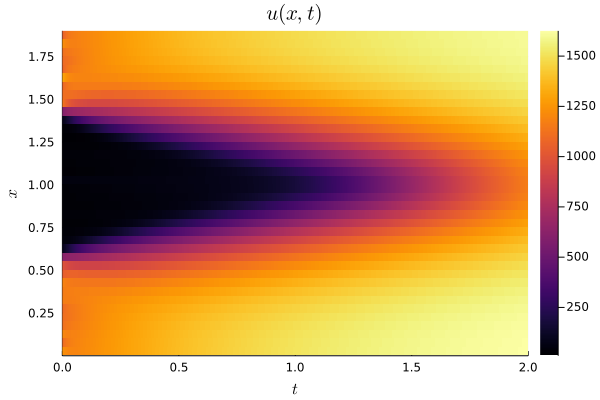

In [5]:
# Build and solve system
sys = VoronoiFVM.System(Ω,flux=J!,reaction=r!,data=θ,species=1,bcondition=u∂Ω)
sol = solve(sys,inival=u0,times=tspan,Δt_min=1e-6)    # default Δt_min too high

# Solution heatmap
t = sol.t
u = vcat(sol.u...)'
plt1 = heatmap(t,x,u,xlabel=L"t",ylabel=L"x",title=L"u(x,t)",fmt=:png)
display(plt1)

Let's plot the data and the PDE solutions at the corresponding times:

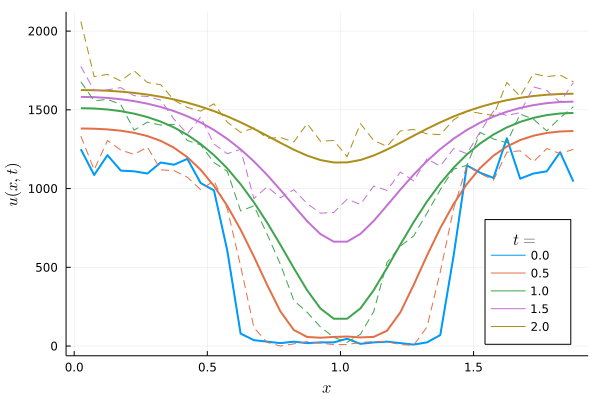

In [6]:
# Solution vs. data plots
T = tdata
U = vcat(sol.(T)...)'
plt2 = plot(x,U,width=2,xlabel=L"x",ylabel=L"u(x,t)",label=T',legendtitle=L"t=",legend=:bottomright)
plt2 = plot!(x,udata,color=theme_palette(:auto)[1:length(T)]',style=:dash,label=false,fmt=:png)
display(plt2)

This looks good! In this tutorial, we merely assumed the model (FKE) and the learned parameters from the literature. It would be a good exercise to go over the actual inverse problem of identifying and parameterizing the models using, e.g., neural networks in a future tutorial.